13
12
10
14
11
13
13


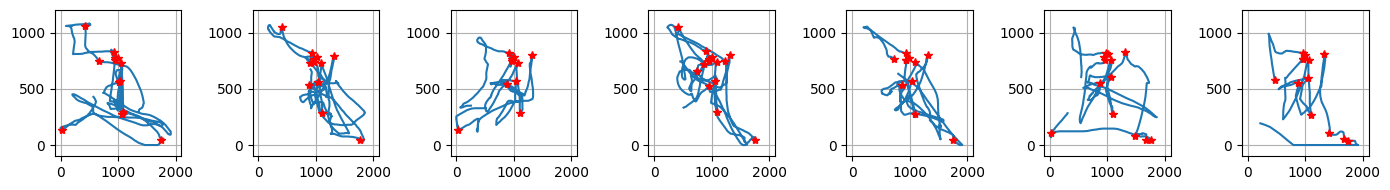

In [37]:
import matplotlib.pyplot as plt
import pandas as pd 
from glob import glob
from monitorlib import load_pcdata

data = load_pcdata('data')

# 1080x1920
plt.figure(figsize=(14,2))
for i,sample in enumerate(data.keys()):
    moves_df = pd.DataFrame(data[sample]['moves'], columns=['px','py'])
    clicks_df = pd.DataFrame(data[sample]['clicks'], columns=['px','py','button'])

    plt.subplot(1,7,i+1)
    plt.plot(moves_df['px'], moves_df['py'])
    plt.xlim([-100,2100])
    plt.ylim([-100,1200])
    plt.grid('on')

    lefts_df = clicks_df[clicks_df['button'] == 'Button.left']
    plt.plot(lefts_df['px'], lefts_df['py'], 'r*')
    print(len(lefts_df))

    rights_df = clicks_df[clicks_df['button'] == 'Button.right']
    plt.plot(rights_df['px'], rights_df['py'], 'g*')

plt.tight_layout()

In [5]:
for sample in data: 
    print('stats ({}):   min   mean   max'.format(sample))
    for typedata in data[sample]:
        x = data[sample][typedata]['timestamp'].values
        if len(x) > 0:
            dx = x[1:] - x[:-1]
            print('{}: '.format(typedata), round(dx.min(),4), round(dx.mean(),4), round(dx.max(),4))
    print()

stats (sample1):   min   mean   max
moves:  0.0 0.0206 4.9641
clicks:  0.7877 3.9108 11.3113
keys:  0.1624 11.6721 45.8135
screenshots:  0.0543 0.0694 0.1013

stats (sample2):   min   mean   max
moves:  0.0 0.0166 2.4485
clicks:  0.8261 3.6179 8.9801
keys:  0.1393 10.6785 41.9518
screenshots:  0.0534 0.0689 0.1101

stats (sample3):   min   mean   max
moves:  0.0 0.0165 1.7024
clicks:  0.9741 3.0811 6.0955
keys:  0.15 8.1187 31.7584
screenshots:  0.0559 0.0702 0.082

stats (sample4):   min   mean   max
moves:  0.0 0.0179 3.2557
clicks:  0.9071 2.8377 6.3096
scrolls:  0.0462 0.057 0.0677
keys:  0.1564 9.3458 36.3598
screenshots:  0.0526 0.0704 0.0831

stats (sample5):   min   mean   max
moves:  0.0 0.0183 2.836
clicks:  0.7699 3.2972 8.2997
keys:  0.1874 10.7754 31.5615
screenshots:  0.0526 0.0693 0.0872

stats (sample6):   min   mean   max
moves:  0.0 0.0205 4.4158
clicks:  0.7237 2.7287 6.1455
keys:  0.1739 8.0409 30.3262
screenshots:  0.0526 0.0693 0.1513

stats (sample7):   min   mea

In [11]:
### sincronizar los datos y verificanlo creando un video con el cursor mostrando sus acciones y las del teclado
from moviepy.editor import *
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# La percepcion (screenshots) comanda la sincronia 
font = ImageFont.truetype("Arial.ttf", 100)

# ¿cual es umbral correcto para la sincronia? 
# El umbral no puede ser mas pequeño que el Ts maximo = 200ms de screenshoot porque podria pasar que el evento no se asocie a nigun screenshoot. 
# Si el umbral es amplio, entonces mas screenshoots seran asociados al mismo evento. 
SyncTHclicks = 0.2
SyncTHscrolls = 0.3
SyncTHkeys = 0.3 

img_list = []
for sample in ['sample7']: 
    for i in range(len(data[sample]['screenshots'])):
        img_path = data[sample]['screenshots']['img_path'][i]
        img = Image.open(img_path)
        img1 = ImageDraw.Draw(img)   

        # Cursor positions
        ti = data[sample]['screenshots']['timestamp'][i]
        abs_diff = abs(data[sample]['moves']['timestamp'] - ti)
        ### duda: debo poner un umbral? No, porque necesitamos visualizar el cursor cuando no se mueve. 
        closest_index = abs_diff.idxmin()
        mx, my = data[sample]['moves']['px'][closest_index], data[sample]['moves']['py'][closest_index]
        img1.polygon([(mx,my),(mx-10,my+20),(mx+10,my+20)], fill ="black", outline ="red")

        # Showing clicks
        abs_diff = abs(data[sample]['clicks']['timestamp'] - ti)
        if abs_diff.min() < SyncTHclicks: 
            closest_index = abs_diff.idxmin()
            cx, cy = data[sample]['clicks']['px'][closest_index], data[sample]['clicks']['py'][closest_index]  
            button = data[sample]['clicks']['button'][closest_index]
            if button == 'Button.left': 
                img1.polygon([(cx,cy),(cx-10,cy+20),(cx+10,cy+20)], fill ="red", outline ="red")
            elif button == 'Button.right': 
                img1.polygon([(cx,cy),(cx-10,cy+20),(cx+10,cy+20)], fill ="yellow", outline ="yellow")

        # Showing scrolls
        abs_diff = abs(data[sample]['scrolls']['timestamp'] - ti)
        if abs_diff.min() < SyncTHscrolls: 
            closest_index = abs_diff.idxmin()
            dx, dy = data[sample]['scrolls']['dx'][closest_index], data[sample]['scrolls']['dy'][closest_index]  
            if dx == 1: 
                img1.text((960, 540), 'up', font = font, align='center', fill='blue')
            if dy == 1: 
                img1.text((960, 540), 'down', font = font, align='center', fill='blue')

        # Showing keyboard events
        abs_diff = abs(data[sample]['keys']['timestamp'] - ti)
        if abs_diff.min() < SyncTHkeys: 
            closest_index = abs_diff.idxmin()
            key = data[sample]['keys']['key'][closest_index].strip("'")
            img1.text((960, 540), key, font = font, align='center', fill='red')

        img_list.append(np.asarray(img))
    ts = (data[sample]['screenshots']['timestamp'][1:].values - data[sample]['screenshots']['timestamp'][:-1].values).mean()
    clip = ImageSequenceClip(img_list, fps=1/ts)
    clip.ipython_display(width = 500, maxduration = 1000) 


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


'\nmask = np.stack([hmap,np.zeros((1080,1920)),np.zeros((1080,1920))], axis=2)\nnew_list = []\nfor img in img_list:\n    new_img = np.clip((50*mask + img), 0, 255)\n    new_list.append(new_img)\n'

In [82]:
## Entrenar un modelo del mundo ?
## Entrenar un modelo prompt -> actions? Ya hay. 
## Entrenar un modelo como el D. ha para letra japneses? 
## Usa PPO para entrenar accines primitvas: dar clic al bottton, arrastrar objetos, esciribr urls, etc. Seria bueno tener un simulador

How to train a RL model to a specific task in a real pc without damage? Usan MiniWoB++ pero no es realizta. 

Contactar a Lucas (segunda vez): mi propuesta 



Cosas que parecen que aun no hay:
1 programa para reoclectar datos de la pc masivamente -> una gran base de datos
2 un modleo del mundo masivo. 


'Key.enter'

In [32]:
from PIL import Image
import numpy as np

x = np.asarray(Image.open('../../Downloads/rgb.jpg')).copy()
d = np.asarray(Image.open('../../Downloads/depth.png'))

mask = 255*np.ones((1080,1920,1))
mask[d > 50] = 0
n = np.concatenate([x,mask],axis=2)


img = Image.fromarray(n.astype('uint8'))
img.show()
img.save('../../Downloads/crop.png')

In [76]:
### dEnfocando la mirada en lo importante e ignorando el resto

from PIL import Image
import numpy as np

def focuscrop(x1, y1, dw, factor):
    def reduce(img, box, factor):
        im = img.crop(box)
        return im.resize((im.size[0]//factor,im.size[1]//factor))
    
    im = img.crop((x1,y1,x1+dw,y1+dw))
    im1 = reduce(img, (0,0,x1,h), factor)
    im2 = reduce(img, (x1+dw,0,w,h), factor)
    im3 = reduce(img, (x1,0,x1+dw,y1), factor)
    im4 = reduce(img, (x1,y1+dw,x1+dw,h), factor)
    return [im, im1, im2, im3, im4]

img = Image.open(data['sample1']['screenshots']['img_path'][4])
w, h = img.size
x = np.asarray(img).copy()

imgs = focuscrop(x1=1920//2, y1 = 1080//2, dw = 300, factor = 5)
[imgs[i].show() for i in range(len(imgs))]

npixels_1 = [imgs[i].size[0]*imgs[i].size[1]*3 for i in range(len(imgs))]
npixels_1 = np.asarray(npixels_1).sum()
npixels_o = img.size[0]*img.size[1]*3
print(npixels_o)
print(npixels_1, round(npixels_1/npixels_o,4)*100, '%')

6220800
508032 8.17 %
